In [1]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"


# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(True)
set_debug(False)

from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from agents import(
    AgentState,
    agents,
    agent_name
)
from tools import get_tools_output, all_tools
from chat_history import save_chat_history, load_chat_history
from langgraph.checkpoint.memory import MemorySaver

## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(all_tools)


def router(state) -> Literal["call_tool", "__end__", "data_collector", "reporter", "analyst"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    if "reporter" in last_message.content:
        return "reporter"
    if "analyst" in last_message.content:
        return "analyst"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
for name, value in agents.items():
    workflow.add_node(name, value['node'])
    
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "analyst",
    router,
    {
        "data_collector":"data_collector",
        "call_tool": "call_tool", 
        "__end__": END,
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "data_collector",
    router,
    {
        "call_tool": "call_tool", 
        "reporter":"reporter",
        "continue": "reporter", 
        }
)

workflow.add_conditional_edges(
    "reporter",
    router,
    {
        "__end__": END,
        "data_collector":"data_collector",
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_name},
)

workflow.add_edge(START, "analyst")
graph = workflow.compile()

def submitUserMessage(
    user_input:str, 
    user_id:str="test", 
    keep_chat_history:bool=False, 
    return_reference:bool=False, 
    verbose:bool=False,
    recursion_limit:int=20
    ) -> str:
    
    chat_history = load_chat_history(user_id=user_id) if keep_chat_history else []
    chat_history = chat_history[-8:]
    
    # memory only keep chat history only along agents.
    internal_level_memory = MemorySaver()
    graph = workflow.compile(checkpointer=internal_level_memory)

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": recursion_limit, "thread_id":"a"},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]
    else:
        for e in events:
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]
    
    response = response["messages"][0].content
    response = response.replace("FINALANSWER:", "")
    response = response.replace("FINALANSWER,", "")
    response = response.replace("FINALANSWER", "")
    
    if keep_chat_history:
        save_chat_history(bot_message=response, human_message=user_input, user_id=user_id)
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

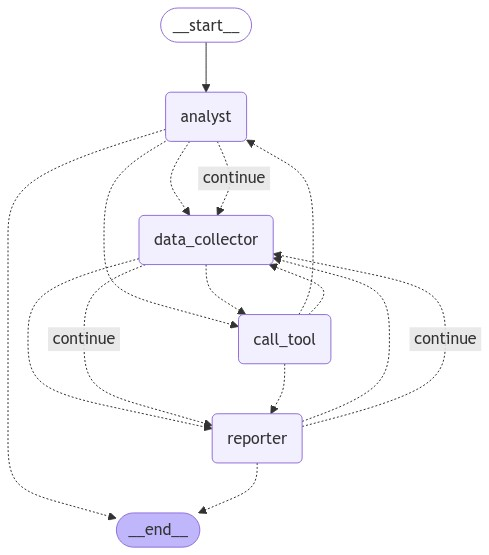

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [3]:
# import utils
result = submitUserMessage("รายงานการวิเคราะห์อสังหาริมทรัพย์ในคลองพระอุดม ปากเกร็ด นนทบุรี", keep_chat_history=True, return_reference=True, verbose=True)
utils.notify(sound_effect="purr")

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  find_place_from_text (call_j7VsatJVQdLfYDNwQbeVN4aK)
 Call ID: call_j7VsatJVQdLfYDNwQbeVN4aK
  Args:
    location: คลองพระอุดม ปากเกร็ด นนทบุรี
  find_place_from_text (call_R9HKWOMZaLmhw71nX99ysDrb)
 Call ID: call_R9HKWOMZaLmhw71nX99ysDrb
  Args:
    location: คลองพระอุดม ปากเกร็ด นนทบุรี
================================= Tool Message =================================
Name: find_place_from_text


    address: คลองพระอุดม ประเทศไทย

    location_name: คลองพระอุดม

    
================================== Ai Message ==================================
Name: analyst

I have identified the location as "คลองพระอุดม ปากเกร็ด นนทบุรี." Now, I will pass this information to the Data Collector for further analysis on the real estate feasibility in that area.
================================== Ai Message ==================================
Name: data_collector
Tool Calls:
  get_geometric_data